In [1]:
import os
import adddeps
from simulator.models import Client_HDF5, Client, SimulationAlchemy as Simulation
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from settings import HDF5_PATH
from sqlalchemy.orm import aliased
from tqdm.notebook import tqdm
import pandas as pd
import re

In [2]:
client = Client()

with client.Session() as sess:
    data = dict()

    subquery = (sess.query(Simulation)
                # .where(Simulation.cls == "SimulatorLennardLammps")
                # .where(Simulation.group_name.in_(["ER 3.303.weak.lammps"]))
                # .where(Simulation.group_name.in_(["time estimate; N vary","ER 3.35.lammps", "time estimate; N vary; partition long", "time estimate; N vary; partition medium; fastrelaxation"]))
                # .where(Simulation.group_name.like(r'%lammps%'))
                # .where(Simulation.group_name.in_(["ER 2", "ER 3"]))
                # .where(Simulation.group_name.in_(["Ensemble 9"]))
                #  .where(Simulation.group_name.in_(["Ensemble 6","Ensemble 7","Ensemble 9"]))
#                 .where(Simulation.particles==523)
                                 .order_by(Simulation.id.asc()).subquery().c)
    
    sess.query(subquery.start_time, subquery.finish_time).all()

    data["time"] = np.array([(f-s).total_seconds() for s,f in 
            sess.query(subquery.start_time, subquery.finish_time).all()
        ])
    
    data["N"] = np.array(sess.query(subquery.particles).all())[:,0]
    data["records"] = np.array(sess.query(subquery.iterations).all())[:,0]

    data["hash"] = np.array(sess.query(subquery.hash).all())[:,0]

    data["iterations"] = (data["records"] 
        / np.array(sess.query(subquery.dt).all())[:,0]
        *np.array(sess.query(subquery.record_interval).all())[:,0])

    data["group_name"] = np.array(sess.query(subquery.group_name).all())[:,0]

    data["name"] = np.array(sess.query(subquery.name).all())[:,0]

    dts = sess.query(subquery.dt).all()

In [3]:
len(data["time"])

19584

In [8]:
data["name"]

array(['elara24', 'elara24', 'elara24', ..., 'elara32', 'tycho06',
       'hermes18'], dtype='<U8')

In [12]:
df = pd.DataFrame({"node":data["name"], "time": data["time"]/data["iterations"], 
             "basenode":[re.findall(r"^(\w+)\d\d$", name)[0] for name in data["name"]]})

In [69]:
gb = df.groupby("basenode")

In [70]:
df_gb = gb.mean(True)
df_gb["count"] = gb.count()["time"]

In [71]:
df_gb = df_gb.sort_values("time")

In [72]:
df_gb.loc["elara", "time"] = np.nan

In [73]:
df_gb[df_gb["time"] > 0.0007].index

Index([], dtype='object', name='basenode')

<Axes: xlabel='basenode'>

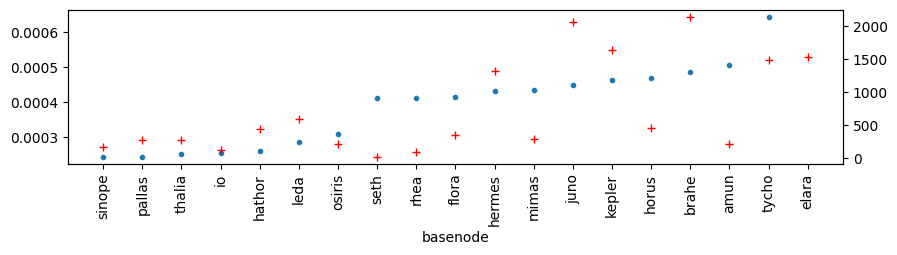

In [74]:
plt.figure(figsize=(10,2))
df_gb["time"].plot(marker=".", lw=0)
plt.gca().set_xticks(range(len(df_gb.index)),df_gb.index, rotation=90);
ax2 = plt.gca().twinx()

df_gb["count"].plot(marker="+",c="r", lw=0, ax=ax2)



0.005441285237095363

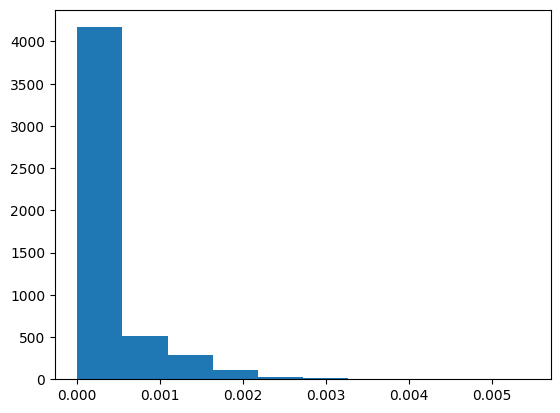

In [7]:
plt.hist(data["time"]/data["iterations"])
max(data["time"]/data["iterations"])

(array([766., 251., 417., 172., 203.,  40.,  20.,   1.,  21.,  24.]),
 array([0.00010176, 0.00019305, 0.00028435, 0.00037565, 0.00046694,
        0.00055824, 0.00064954, 0.00074083, 0.00083213, 0.00092343,
        0.00101472]),
 <BarContainer object of 10 artists>)

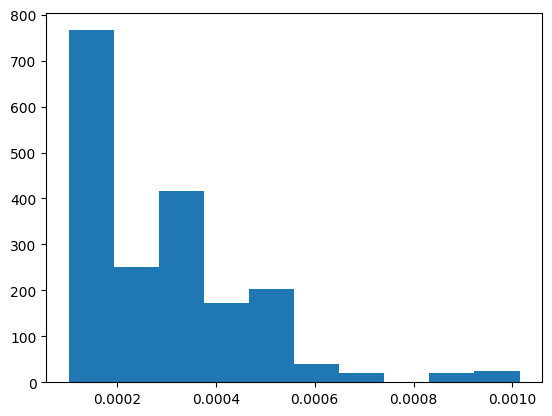

In [8]:
plt.hist((data["time"]/data["iterations"])[data["N"]==523])

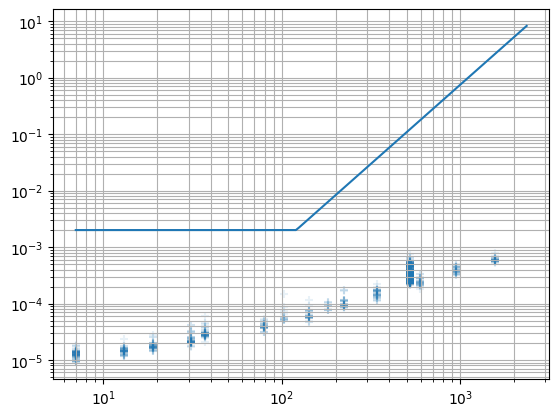

In [36]:
def f(n):
    return np.maximum(2e-3,  1.0e-7 * n**2.8 * 0.03)

plt.scatter(data["N"], data["time"]/data["iterations"],marker="+", alpha=0.1)
x=np.linspace(min(data["N"]), max(1.5*data["N"]),500)
plt.plot(x, f(x))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(which="both")
plt.minorticks_on()

In [9]:
set(data["group_name"])

{'BO 2.lammps',
 'BO 3.lammps',
 'ER 3.1.skin.lammps',
 'ER 3.13.skin.lammps',
 'ER 3.15.skin.lammps',
 'ER 3.3.lammps',
 'ER 3.303.weak.lammps',
 'ER 3.32.lammps',
 'ER 3.35.lammps',
 'ER 3.403.weak.lammps',
 'ER 3.404.weak.lammps',
 'time estimate; N vary',
 'time estimate; N vary; partition long',
 'time estimate; N vary; partition medium; fastrelaxation'}

In [10]:
0.038*(125/550)**(1/4)

0.02623737771644334

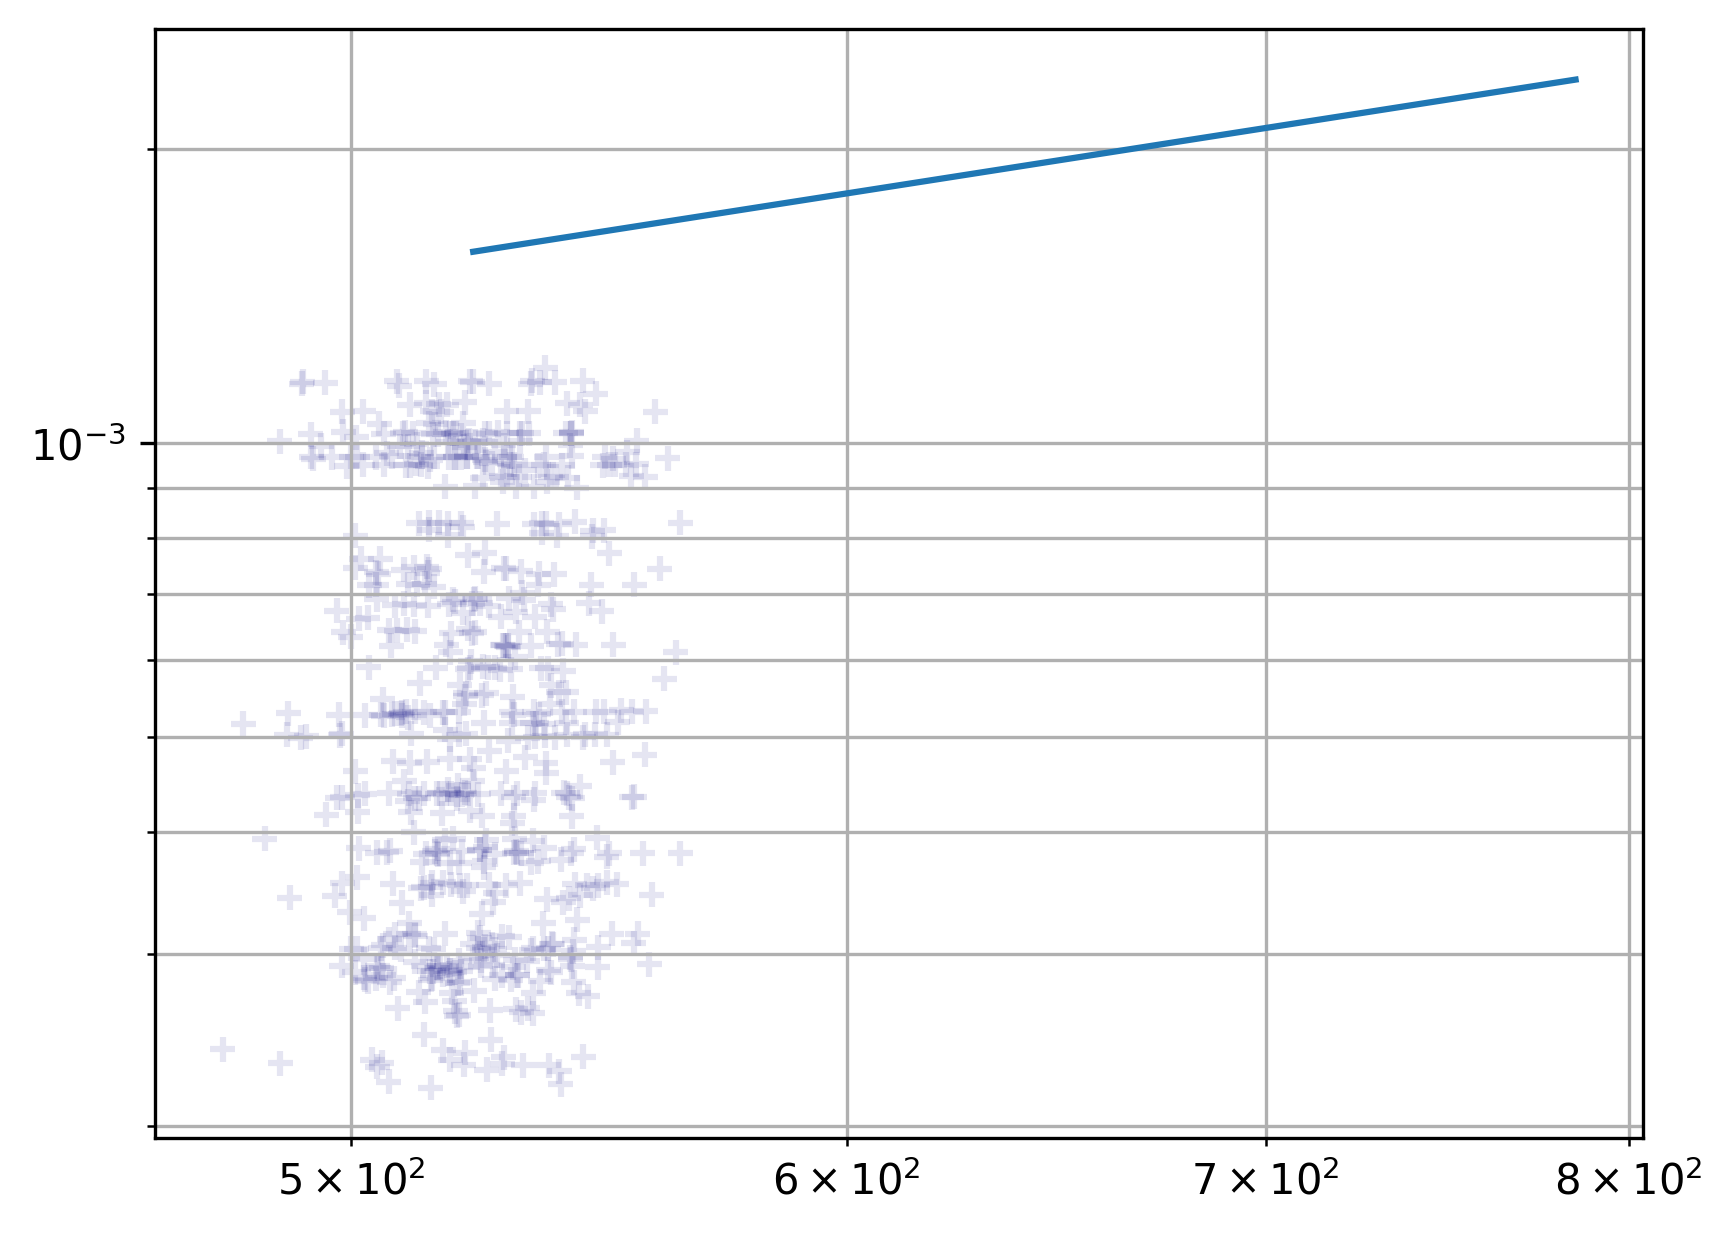

In [7]:
def f(n):
    return np.maximum(5e-5,1.0e-6 * n**1 *3)
    return np.maximum(2e-3,  1.0e-7 * n**2.8 * 0.03)
plt.figure(dpi=300)
plt.scatter(data["N"]*(1+0.03*np.random.randn(len(data["N"]))),
             data["time"]/data["iterations"],marker="+",alpha=0.1,
             c=data["group_name"]=="ER 3.303.weak.lammps",
             cmap="jet")
x=np.linspace(min(data["N"]), max(1.5*data["N"]),1000)
plt.plot(x, f(x))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(which="both")
plt.minorticks_on()

In [11]:
np.max(data["time"]/data["iterations"])

0.0011932078935731252

In [13]:
0.0012 * 705000 * 1000 / 86400

9.791666666666666

In [10]:
data["N"]

array([ 169,   31,  379,  769,  895,  169,  769,  895,  277,  169,  769,
        277,  523,  277,  169,   31,  631,  277,  523,  631,  277,  895,
        631,  379,   31,  631,  523,  277,  769,   31,  379,  631,  379,
        895,  895,  769,  631,  379,  631, 1009,  379,  631,  379, 1009,
         31,  169,  895,  895, 1009,  379,  769,   31,  379,  277,  895,
        769,  523,  769,  169,  631,  277,   31,  379, 1009,  169,  523,
        523,  169,   31,  523,  277,   31, 1009,  769,  631,  523,  895,
        169,  277,  379,  769,  523,  631,  769, 1009,  631,  523,  769,
        523,   31,  379,  769,  895,  379,  277,  277,  523,   31,  379,
        169,  895,  169,  895,  631,  631,  895,  169,  631,   31,  277,
         31,  523,  769,  379,   31,  277,   31,  769,  169,  769,  169,
        379,  895, 1009,  895,  631,  379,  769,  277,  769,  379,  631,
        631,  523,  379,  895,  523,  169,  631,  631,  769,  523,  277,
        523,  277,  523,  895,  277,  769,  169,   

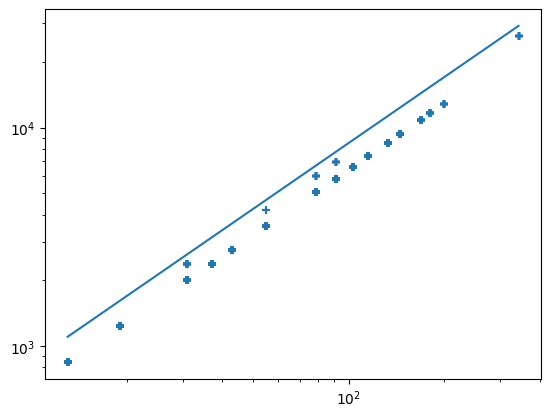

In [73]:
def f(n):
    return (85 * n)*1.0

plt.scatter(data["N"], data["size"]/data["records"],marker="+")
x=np.linspace(min(data["N"]), max(data["N"]),500)
plt.plot(x, f(x))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

In [17]:
x.total_seconds()

50421.32185

In [15]:
len(data)

5882

In [17]:
data[1]-data[0]

TypeError: unsupported operand type(s) for -: 'Row' and 'Row'

In [13]:
data[1]-data[0]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Analyse memory usage

In [4]:

sizes = []
for _hash in tqdm(data["hash"]):
    path = os.path.join(HDF5_PATH, _hash+".hdf5")
    if os.path.exists(path):
        sizes.append(os.stat(path).st_size)
    else:
        sizes.append(0)
data["size"] = np.array(sizes)

  0%|          | 0/19584 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(
    {key:data[key] for key in ["group_name", "hash", "size"]})

In [6]:
gb = df.groupby("group_name")

In [7]:
size_per_group = gb["size"].sum() / (1000**4)

In [8]:
size_per_group.sort_values()

group_name
test lammps                                                 0.000008
Ensemble 9.1                                                0.049219
Ensemble 4                                                  0.066892
ER 1                                                        0.140080
time estimate; N vary; partition long                       0.172802
ER 6.3                                                      0.261569
CtR 6.2                                                     0.309861
time estimate; N vary                                       0.309963
Ensemble 9                                                  0.320936
Ensemble 5.1                                                0.323119
time estimate; N vary; partition medium; fastrelaxation     0.324787
FM 1.1                                                      0.438313
ER 3.631.weak.lammps                                        0.445970
GE 1.0                                                      1.569369
BO 1.1.lammps          

In [9]:
df["size"].sum()/(1000**4)

68.13093758714

In [10]:
df["size"].sum()/(1000**4)

68.13093758714